In [1]:
# 功能模組
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

#TEJ API
import tejapi

tejapi.ApiConfig.api_key = 'Your Key'

In [2]:
# 匯入 台灣交易所所有代碼
code = tejapi.get("TWN/EWNPRCSTD",
                  paginate=True,
                  opts={'columns':['coid', 'mdate', 'stypenm','market','tseindnm']},
                  chinese_column_name=True)

# 只留上市櫃非金融業普通股公司
code = code[(code["證券種類名稱"] == "普通股") &
            (code["上市別"].isin(["TSE","OTC"])) &
            (code['TSE產業名'] != '金融業')]

# 匯入 財務資料
data = tejapi.get('TWN/AIM1A',
                  coid = code['證券碼'].tolist(),
                  mdate= {'gte': '2012-01-01','lte':'2020-12-31'},
                  opts={'pivot':True,
                        'columns':['coid', 'mdate','0010','0130','R531',
                                   '7210','3100','0400','3990']},
                  chinese_column_name=True,
                          paginate=True)

# 匯入 財報發布日 
data_annouce = tejapi.get('TWN/AIFINA',
                          coid = code['證券碼'].tolist(),
                          mdate= {'gte': '2012-01-01','lte':'2020-12-31'},
                          opts={'columns':['coid', 'mdate', 'a0003']},
                          chinese_column_name=True,
                          paginate=True)

# 將公司以50家為一組，避免到時撈資料時一次撈取過多，而導致撈取失敗的情況。
code_list = code['證券碼'].tolist()
groups = []
while True:
    if len(code_list) >= 50:
        groups.append(code_list[:50])
        code_list = code_list[50:]
    elif 0 <= len(code_list) < 50:
        groups.append(code_list)
        break

# 匯入調整後股價
data_price = pd.DataFrame()    
for group in groups:
    data_price = data_price.append(tejapi.get('TWN/APRCD1',
                                              coid = group,
                                              mdate= {'gte': '2013-03-01','lte':'2021-3-31'},
                                              opts={'columns':['coid', 'mdate','close_adj']},
                                              chinese_column_name = True,
                                              paginate = True)).reset_index(drop=True)

In [3]:
# 資料前處理
code = code.rename({'證券碼': '公司'}, axis=1) # 改名字
data = data.rename({'公司代碼':'公司'}, axis=1) # 改名字
data_annouce = data_annouce.rename({'年/月':'財報年月'}, axis=1) # 改名字
data_price = data_price.rename({'證券代碼':'公司'}, axis=1) # 改名字

data_price['年'] = data_price['年月日'].dt.year - 1 # 改成財報年
data_price = data_price[data_price['年月日'].dt.month == 3]
data_price = data_price.drop_duplicates(subset=['公司','年'], keep='last') # 只保留三月底收盤價

data['年'] = data['財報年月'].dt.year
data = data.drop_duplicates(subset=['公司','年'], keep='last') # 只保留年底資料

In [4]:
# 合併資料
data = data.merge(code[['TSE產業名','公司']] ,how = 'left' ,on=['公司']) 
data = data.merge(data_annouce,how = 'left' ,on=['公司','財報年月'])
data = data.merge(data_price[['公司','年','收盤價(元)']] ,how = 'left' ,on=['公司','年'])

data.head(5)

,公司,財報年月,資產總額,應收帳款及票據,常續性稅後淨利,來自營運之現金流量,營業收入淨額,不動產廠房及設備,每股盈餘,年,TSE產業名,財報發布日,收盤價(元)
0,1101,2012-12-01 00:00:00+00:00,273948486.0,19498993.0,9297087.0,25434756.0,113699313.0,104289140.0,2.11,2012,水泥工業,2013-05-15 00:00:00+00:00,18.7119
1,1101,2013-12-01 00:00:00+00:00,282680739.0,25597371.0,14713470.0,21973605.0,116098947.0,109369671.0,2.72,2013,水泥工業,2014-03-31 00:00:00+00:00,24.6698
2,1101,2014-12-01 00:00:00+00:00,292743832.0,26543620.0,16420654.0,19904673.0,118325809.0,108445563.0,2.93,2014,水泥工業,2015-03-31 00:00:00+00:00,24.3603
3,1101,2015-12-01 00:00:00+00:00,293066355.0,20212952.0,6803992.0,21763392.0,93679076.0,113310134.0,1.56,2015,水泥工業,2016-03-31 00:00:00+00:00,18.5837
4,1101,2016-12-01 00:00:00+00:00,266988696.0,19929687.0,9636065.0,18750155.0,89564306.0,101799766.0,1.72,2016,水泥工業,2017-03-29 00:00:00+00:00,22.2652


In [5]:
# 計算 DCA 
data['DCA 前期資產總額倒數'] = 1 / data.groupby('公司')['資產總額'].shift(1) # X0
data['DCA 營業收入差'] = data.groupby('公司')['營業收入淨額'].diff() * data['DCA 前期資產總額倒數'] # X1
data['DCA 不動產廠房及設備'] = data['不動產廠房及設備'] * data['DCA 前期資產總額倒數'] # X2
data['DCA 營業收入差 - 應收差'] = (data.groupby('公司')['營業收入淨額'].diff() - \
                           data.groupby('公司')['應收帳款及票據'].diff()) * data['DCA 前期資產總額倒數'] # X3

data['Total accrual'] = (data['常續性稅後淨利'] - data['來自營運之現金流量']) * data['DCA 前期資產總額倒數'] # Y

# 分組相似產業
data['產業分組'] = \
    np.select([(data['TSE產業名'].isin(["食品工業","紡織纖維","造紙工業"])) ,
               (data['TSE產業名'].isin(["塑膠工業","橡膠工業","化學工業","油電燃氣業"])),
               (data['TSE產業名'].isin(["汽車工業","鋼鐵工業"])),
               (data['TSE產業名'].isin(["電機機械","電器電纜"])),
               (data['TSE產業名'].isin(["水泥工業","建材營造","玻璃陶瓷"])),
               (data['TSE產業名'].isin(["資訊服務業","電子商務","貿易百貨"])),
               (data['TSE產業名'].isin(["觀光事業","航運業","文化創意業"])),
               (data['TSE產業名'].isin(["生技醫療"])),
               (data['TSE產業名'].isin(["光電業"])),
               (data['TSE產業名'].isin(["半導體"])),
               (data['TSE產業名'].isin(["電腦及週邊"])),
               (data['TSE產業名'].isin(["通信網路業"])),
               (data['TSE產業名'].isin(["電子零組件"])),
               (data['TSE產業名'].isin(["其他電子業","電子通路業","農業科技","其他"]))],
              list(range(14)), default = np.nan)

data.head(5)

,公司,財報年月,資產總額,應收帳款及票據,常續性稅後淨利,來自營運之現金流量,營業收入淨額,不動產廠房及設備,每股盈餘,年,TSE產業名,財報發布日,收盤價(元),DCA 前期資產總額倒數,DCA 營業收入差,DCA 不動產廠房及設備,DCA 營業收入差 - 應收差,Total accrual,產業分組
0,1101,2012-12-01 00:00:00+00:00,273948486.0,19498993.0,9297087.0,25434756.0,113699313.0,104289140.0,2.11,2012,水泥工業,2013-05-15 00:00:00+00:00,18.7119,NaN,NaN,NaN,NaN,NaN,4.0
1,1101,2013-12-01 00:00:00+00:00,282680739.0,25597371.0,14713470.0,21973605.0,116098947.0,109369671.0,2.72,2013,水泥工業,2014-03-31 00:00:00+00:00,24.6698,3.650321e-09,0.008759,0.399234,-0.013502,-0.026502,4.0
2,1101,2014-12-01 00:00:00+00:00,292743832.0,26543620.0,16420654.0,19904673.0,118325809.0,108445563.0,2.93,2014,水泥工業,2015-03-31 00:00:00+00:00,24.3603,3.537560e-09,0.007878,0.383633,0.004530,-0.012325,4.0
3,1101,2015-12-01 00:00:00+00:00,293066355.0,20212952.0,6803992.0,21763392.0,93679076.0,113310134.0,1.56,2015,水泥工業,2016-03-31 00:00:00+00:00,18.5837,3.415956e-09,-0.084192,0.387062,-0.062567,-0.051101,4.0
4,1101,2016-12-01 00:00:00+00:00,266988696.0,19929687.0,9636065.0,18750155.0,89564306.0,101799766.0,1.72,2016,水泥工業,2017-03-29 00:00:00+00:00,22.2652,3.412197e-09,-0.014040,0.347361,-0.013074,-0.031099,4.0


In [6]:
data = data[data['收盤價(元)'] >= 10] # 刪除股價低於10的個股
data = data[data['年'] >= 2013] # 僅保留2013年以後的資料

# 計算 DCA
def regress(data):
    '''
    每年不同產業分組跑迴歸，主要用來獲得迴歸係數
    '''
    data = data[['Total accrual','DCA 前期資產總額倒數','DCA 營業收入差','DCA 不動產廠房及設備']].dropna()
    Y = data['Total accrual']
    X = data[['DCA 前期資產總額倒數','DCA 營業收入差','DCA 不動產廠房及設備']]
    X = X.rename(columns={"DCA 前期資產總額倒數": "alpha 前期資產總額倒數",
                          "DCA 營業收入差": "alpha 營業收入差",
                          "DCA 不動產廠房及設備": "alpha 不動產廠房及設備",})
    try:
        result = sm.OLS(Y, X).fit()
        return result.params
    except ValueError:  
        pass

data = data.merge(data.groupby(['財報年月','產業分組']).apply(regress).reset_index(),
                        how = 'left' ,on = ['財報年月','產業分組'])

data['Normal accrual'] = (data['alpha 前期資產總額倒數'] * data['DCA 前期資產總額倒數'] \
                          + data['alpha 營業收入差'] * data['DCA 營業收入差 - 應收差'] \
                              + data['alpha 不動產廠房及設備'] * data['DCA 不動產廠房及設備'])

data['DCA'] = data['Total accrual'] - data['Normal accrual']

In [7]:
# 計算益本比，並以0.0125分組。
def cal_EP_label():
    '''獲得 EP ratio分組下的公司數，num=33，切0.025'''
    label = np.linspace(-0.2, 0.2, num=33).tolist()
    label = [ '%.4f' % elem for elem in label ]
    label.insert(0,-np.inf)
    label.insert(len(label),np.inf)
    label = np.array(label, dtype=float)
    return label

data['益本比'] = data['每股盈餘'] / data['收盤價(元)']
data['益本比分組'] = pd.cut(data['益本比'],bins = cal_EP_label() ,right=True)

data.head(5)

,公司,財報年月,資產總額,應收帳款及票據,常續性稅後淨利,來自營運之現金流量,營業收入淨額,不動產廠房及設備,每股盈餘,年,...,DCA 營業收入差 - 應收差,Total accrual,產業分組,alpha 前期資產總額倒數,alpha 營業收入差,alpha 不動產廠房及設備,Normal accrual,DCA,益本比,益本比分組
0,1101,2013-12-01 00:00:00+00:00,282680739.0,25597371.0,14713470.0,21973605.0,116098947.0,109369671.0,2.72,2013,...,-0.013502,-0.026502,4.0,795847.480545,0.350817,-1.177723,-0.472019,0.445517,0.110256,"(0.1, 0.112]"
1,1101,2014-12-01 00:00:00+00:00,292743832.0,26543620.0,16420654.0,19904673.0,118325809.0,108445563.0,2.93,2014,...,0.004530,-0.012325,4.0,23066.629048,-0.102714,0.058659,0.022120,-0.034445,0.120278,"(0.112, 0.125]"
2,1101,2015-12-01 00:00:00+00:00,293066355.0,20212952.0,6803992.0,21763392.0,93679076.0,113310134.0,1.56,2015,...,-0.062567,-0.051101,4.0,176578.586961,-0.318442,-0.155672,-0.039728,-0.011373,0.083945,"(0.075, 0.0875]"
3,1101,2016-12-01 00:00:00+00:00,266988696.0,19929687.0,9636065.0,18750155.0,89564306.0,101799766.0,1.72,2016,...,-0.013074,-0.031099,4.0,140093.567321,-0.127786,-0.126069,-0.041643,0.010544,0.077251,"(0.075, 0.0875]"
4,1101,2017-12-01 00:00:00+00:00,272557049.0,27306164.0,10983992.0,12310560.0,98311776.0,94709404.0,2.03,2017,...,0.005135,-0.004969,4.0,88752.554325,-0.206183,-0.090202,-0.032724,0.027755,0.086903,"(0.075, 0.0875]"


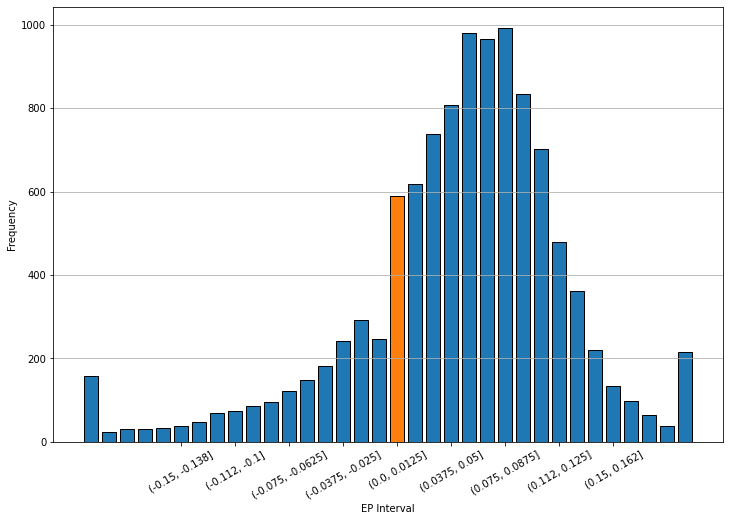

In [8]:
#%% 做圖觀察益本比分布狀況

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot()

factor = data.groupby(['益本比分組'])['公司'].count().reset_index()['益本比分組'].astype(str)
value = data.groupby(['益本比分組'])['公司'].count().reset_index()['公司']
ax.bar(factor,value,fill = '#eb3434',edgecolor = 'black')
ax.bar('(0.0, 0.0125]',value[17],fill = '#eb344f',edgecolor = 'black')

ax.set_xticks(['(-0.15, -0.138]','(-0.112, -0.1]','(-0.075, -0.0625]','(-0.0375, -0.025]','(0.0, 0.0125]',
              '(0.0375, 0.05]','(0.075, 0.0875]','(0.112, 0.125]','(0.15, 0.162]'])
plt.grid(axis='y')
plt.xticks(rotation=30)
plt.xlabel('EP Interval')
plt.ylabel('Frequency')
plt.show()

In [9]:
#%% 做表觀察益本比分組與盈餘管理程度關係

def cal_wilcoxon(group):
    return pd.DataFrame({'DCA': group.median(),
                         'p-value': wilcoxon(group)[1]}, index = [0])

def add_star(df,p_value):
    '''
    p-values of the Wilcoxon signed rank test <= 0.01，則係數新增***
    0.01 < p-values of the Wilcoxon signed rank test <= 0.05，則係數新增**
    0.1 < p-values of the Wilcoxon signed rank test <= 0.01，則係數新增*
    '''
    df = np.select([(p_value <= 0.01),
                      (p_value > 0.01) & (p_value <= 0.05),
                      (p_value > 0.05) & (p_value <= 0.1)],
                     [df.apply(lambda x: '%.3f'%x + '***'),
                      df.apply(lambda x: '%.3f'%x + '**'),
                      df.apply(lambda x: '%.3f'%x + '*')],
                     default = df.apply(lambda x: '%.3f'%x))
    return df

def run_data_cal_wilcoxon(df):
    '''p-values of the Wilcoxon signed rank test for one sample median DCA equal to 0'''
    finaldf = pd.DataFrame()
    
    for data in df:
        
        temp = data.dropna(subset=['DCA']).groupby('年')['DCA'].\
            apply(cal_wilcoxon).reset_index(level=1, drop=True)
        
        temp.loc['All','DCA'] = data.dropna(subset=['DCA'])['DCA'].median()
        temp.loc['All','p-value'] = wilcoxon(data.dropna(subset=['DCA'])['DCA'])[1]
        
        temp['DCA'] = add_star(temp['DCA'],temp['p-value'])
        temp['p-value'] = temp['p-value'].apply(lambda x: '(' + '%.3f'%x + ')')
    
        finaldf = pd.concat([finaldf, temp], axis=1)   
        
    return finaldf


Table = run_data_cal_wilcoxon([data,
                               data[data['益本比分組'].astype(str).isin(['(-0.0125, 0.0]'])],
                               data[data['益本比分組'].astype(str).isin(['(0.0, 0.0125]'])]])

Table.columns = ['全部公司','Wilcoxon signed rank test',
                 '(-0.0125, 0.0]','Wilcoxon signed rank test',
                 '(0.0, 0.0125]','Wilcoxon signed rank test']

Table

,全部公司,Wilcoxon signed rank test,"(-0.0125, 0.0]",Wilcoxon signed rank test,"(0.0, 0.0125]",Wilcoxon signed rank test
年,,,,,,
2013,-0.006**,(0.023),0.002,(0.611),-0.015,(0.489)
2014,0.000,(0.946),-0.005,(0.200),0.017,(0.130)
2015,-0.006***,(0.004),0.002,(0.790),0.005,(0.390)
2016,-0.002*,(0.062),-0.006,(0.562),0.010,(0.197)
2017,0.004*,(0.097),0.015,(0.159),0.025***,(0.001)
2018,0.000,(0.925),0.014,(0.773),-0.005,(0.170)
2019,-0.008***,(0.000),0.034,(0.421),0.011**,(0.026)
2020,-0.004***,(0.008),-0.000,(0.846),-0.002,(0.726)
All,-0.002***,(0.000),0.005,(0.626),0.005**,(0.025)
